In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

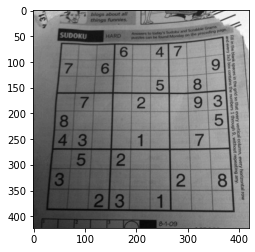

In [85]:
img = cv.imread("sudoku.jpg", 0)
plt.imshow(img, cmap="gray")

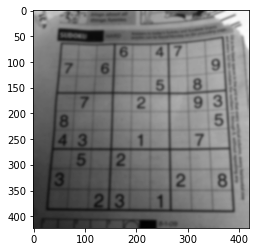

In [86]:
blurred_img = cv.GaussianBlur(img.copy(), (11,11), 0)
plt.imshow(blurred_img, cmap='gray')

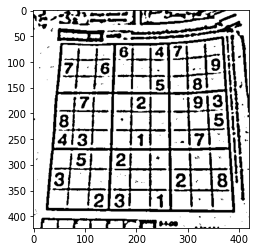

In [87]:
th = cv.adaptiveThreshold(blurred_img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
plt.imshow(th, cmap='gray')

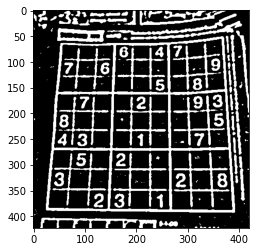

In [88]:
neg = cv.bitwise_not(th)
plt.imshow(neg, cmap='gray')

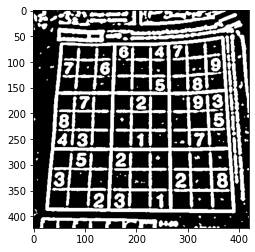

In [89]:
# dilate to fill in cracks
kernel = np.array([[0., 1., 0.], [1., 1., 1.],[0., 1., 0.]], np.uint8)
dilated = cv.dilate(neg, kernel)
plt.imshow(dilated, cmap='gray')

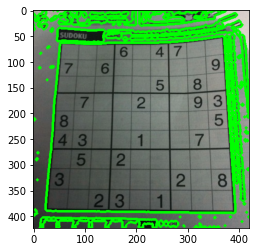

In [220]:
# find the contours from the thresholded image
color_img = cv.imread("sudoku.jpg")
contours, hierarchy = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv.contourArea, reverse=True)
drawn_contours = cv.drawContours(color_img, contours, -1, (0,255,0), 3)
plt.imshow(drawn_contours)

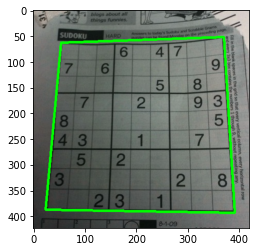

In [208]:
puzzle_contour = None

for c in contours:
    perimeter = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.015 * perimeter, True)
    if len(approx) == 4:
        puzzle_contour = approx
        break
        
if puzzle_contour is None:
    print("error")
else:
    color_img = cv.imread("sudoku.jpg")
    drawn_contours = cv.drawContours(color_img, [puzzle_contour], -1, (0,255,0), 3)
    plt.imshow(drawn_contours)

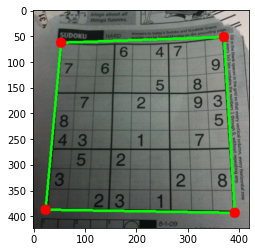

In [209]:
corner_img = color_img.copy()
for point in puzzle_contour.reshape(4,2):
    corner_img = cv.circle(corner_img, (point[0], point[1]), radius=10, color=(255,0,0), thickness=-1)
plt.imshow(corner_img)

In [210]:
# need to crop and fix skew on image

# order points
def order_points(pts):
    # points will be ordered clockwise starting from top left 
    rect = np.zeros((4,2), dtype="float32")
    
    # top left will have smallest sum
    # bottom right will have largest sum
    point_sums = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(point_sums)]
    rect[2] = pts[np.argmax(point_sums)]
    
    # top right will have smallest difference
    # bottom left will have largest difference
    point_diffs = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(point_diffs)]
    rect[3] = pts[np.argmax(point_diffs)]
    
    return rect

In [211]:
print(order_points(puzzle_contour.reshape(4,2)))

[[ 54.  63.]
 [370.  52.]
 [391. 393.]
 [ 24. 387.]]


In [212]:
cv.norm((54,63), (370, 52), cv.NORM_L2)

316.1913977324494

In [213]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, bl, br) = rect
    
    max_width = max(int(cv.norm(tl, tr, cv.NORM_L2)),
                    int(cv.norm(bl, br, cv.NORM_L2)))
    
    max_height = max(int(cv.norm(tl, bl, cv.NORM_L2)),
                    int(cv.norm(tr, br, cv.NORM_L2)))
    
    dst = np.array([
        [0, 0],
        [max_width-1, 0],
        [max_width-1, max_height-1],
        [0, max_height-1]], dtype="float32")
    
    M = cv.getPerspectiveTransform(rect, dst)
    print(M)
    result = cv.warpPerspective(image, M, (max_width, max_height))
    return result

[[ 1.27221851e+00  1.17798010e-01 -7.61210741e+01]
 [ 6.24692170e-02  1.79457023e+00 -1.16431262e+02]
 [ 1.82689508e-04  5.24666751e-04  1.00000000e+00]]


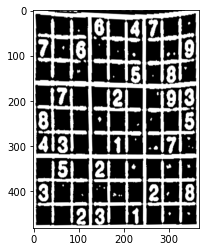

In [214]:
cropped_img = four_point_transform(dilated, puzzle_contour.reshape(4,2))
plt.imshow(cropped_img, cmap="gray")

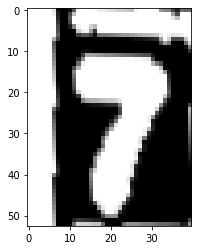

In [205]:
strideY = cropped_img.shape[0] // 9
strideX = cropped_img.shape[1] // 9
plt.imshow(cropped_img[strideY*1:strideY*2, strideX*0:strideX*1], cmap='gray')

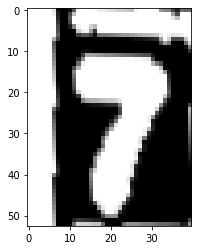

In [233]:
cell = cropped_img[strideY*1:strideY*2, strideX*0:strideX*1]
plt.imshow(cell, cmap='gray')

In [234]:
from skimage.segmentation import clear_border

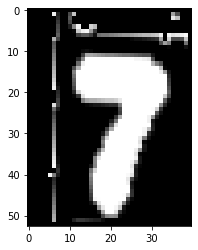

In [241]:
cell = clear_border(cell)
plt.imshow(cell, cmap='gray')

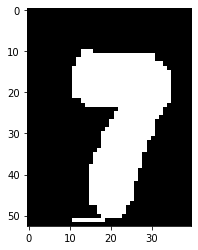

In [242]:
cnts, _ = cv.findContours(cell.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

c = max(cnts, key=cv.contourArea)
mask = np.zeros(cell.shape, dtype="uint8")
plt.imshow(cv.drawContours(mask, [c], -1, 255, -1), cmap='gray')

False


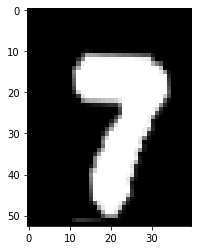

In [244]:
(h, w) = cell.shape
percentFilled = cv.countNonZero(mask) / float(w*h)

print(percentFilled < 0.03)

digit = cv.bitwise_and(cell, cell, mask=mask)
plt.imshow(digit, cmap='gray')

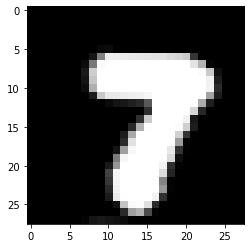

In [247]:
digit = cv.resize(digit, (28,28))
plt.imshow(digit, cmap='gray')

In [252]:
from PIL import Image

In [260]:
export_array = cv.bitwise_not(digit)
export = Image.fromarray(export_array)
export.save("seven.bmp")